# Plotting EEG Topomap of Alpha/Theta Ratio with MNE

[MNE](https://mne.tools/dev/index.html) is a popular python toolbox for analyzing neural data, and it has a lot of visualization capabilities. In this tutorial, we show how to interface between `naplib-python` and `mne` to produce EEG topomaps.

In [51]:
import os
from os import path
import openneuro
from mne.datasets import sample
from mne_bids import print_dir_tree
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.viz import plot_topomap

from naplib.io import read_bids

### First, let's download some EEG data from OpenNeuro

In [3]:
dataset = 'ds002778'
subject = 'pd6'

bids_root = path.join(path.dirname(sample.data_path()), dataset)
print(bids_root)
if not path.isdir(bids_root):
    os.makedirs(bids_root)


/home/gavin/mne_data/ds002778


In [ ]:
openneuro.download(dataset=dataset, target_dir=bids_root,
                   include=[f'sub-{subject}'])

### Next, we read the data into an OutStruct

In [14]:
# We are only interested in the 32-channel EEG data as the responses, so select those channels
resp_channels = ['Fp1','AF3','F7','F3','FC1','FC5','T7','C3','CP1','CP5','P7',
                 'P3','Pz','PO3','O1','Oz','O2','PO4','P4','P8','CP6','CP2',
                 'C4','T8','FC6','FC2','F4','F8','AF4','Fp2','Fz','Cz']

outstruct = read_bids(root=bids_root, subject=subject, datatype='eeg', task='rest', suffix='eeg', session='off', resp_channels=resp_channels)
outstruct

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 21.54it/s]


OutStruct of 2 trials containing 8 fields
[{"event_index": <class 'int'>, "description": <class 'numpy.str_'>, "stim": <class 'numpy.ndarray'>, "stim_ch_names": <class 'list'>, "resp": <class 'numpy.ndarray'>, "befaft": <class 'list'>, "sfreq": <class 'float'>, "ch_names": <class 'list'>}
{"event_index": <class 'int'>, "description": <class 'numpy.str_'>, "stim": <class 'numpy.ndarray'>, "stim_ch_names": <class 'list'>, "resp": <class 'numpy.ndarray'>, "befaft": <class 'list'>, "sfreq": <class 'float'>, "ch_names": <class 'list'>}]

### Perform Analysis

Let's compute the Alpha/Theta Ratio in each channel. We use the log-value so that ratios above 1 are positive and ratios below 1 are negative, which makes the resulting topomap more clear.

In [69]:
def log_alpha_theta_ratio(response, sfreq):
    '''response should be of shape (time * channels)'''
    # must transpose response for mne function
    alpha_psd, _ = mne.time_frequency.psd_array_welch(response.T, sfreq, fmin=8, fmax=13, verbose=False) # psd is shape (channels * freqs)
    alpha_psd = alpha_psd.mean(-1)
    
    theta_psd, _ = mne.time_frequency.psd_array_welch(response.T, sfreq, fmin=4, fmax=8, verbose=False) # psd is shape (channels * freqs)
    theta_psd = theta_psd.mean(-1)
    
    return np.log(alpha_psd / theta_psd)
    

In [70]:
alpha_theta_ratio = [log_alpha_theta_ratio(trial['resp'], trial['sfreq']) for trial in outstruct]

### Visualize Results

In [39]:
# The outstruct contains the mne_info attribute (outstruct.mne_info) which we can use for plotting
# This info is an instance of mne.Info, and it contains measurement information
# like channel names, locations, etc, as well as other metadata

# First, we need to set the montage (i.e. the arrangement of electrodes) so that the channels can be plotted properly
# Here, we set it to the standard 10-20 system, but many options are available if the data were recorded in a different
# montage. See https://mne.tools/dev/generated/mne.channels.make_standard_montage.html for details
outstruct.mne_info.set_montage('standard_1020')

<Info | 12 non-empty values
 bads: []
 ch_names: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, ...
 chs: 32 EEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 35 items (3 Cardinal, 32 EEG)
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 104.0 Hz
 meas_date: 2011-02-18 13:07:18 UTC
 nchan: 32
 projs: []
 sfreq: 512.0 Hz
 subject_info: 9 items (dict)
>

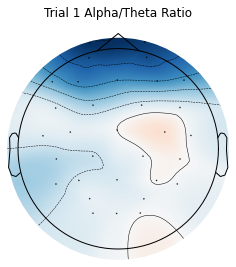

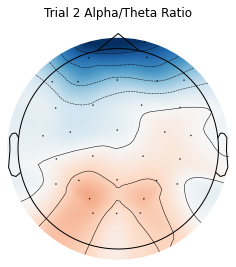

In [78]:
plt.figure()
plt.title('Trial 1 Alpha/Theta Ratio')
plot_topomap(alpha_theta_ratio[0], outstruct.mne_info)
plt.show()

plt.figure()
plt.title('Trial 2 Alpha/Theta Ratio')
plot_topomap(alpha_theta_ratio[1], outstruct.mne_info)
plt.show()
